# **BACKGROUND / PROBLEM**

A indonesia automotive company ASTRA aspires to enter the World market by setting up their manufacturing unit there and producing cars locally to give competition to their US and European counterparts.

They have contracted an automobile consulting company to understand the factors on which the pricing of cars depends. Specifically, they want to understand the factors affecting the pricing of cars in the World market, since those may be very different from the Indonesian market. The company wants to know:

Which variables are significant in predicting the price of a car
How well those variables describe the price of a car
Based on various market surveys, the consulting firm has gathered a large data set of different types of cars across the World market.

# **BUSINESS GOAL**

This will be used by management to understand how prices actually vary with the independent variables. Therefore, they can manipulate car designs, business strategies, etc. to meet a certain price level. Furthermore, this model will be a good way for management to understand price dynamics in new markets.

In [384]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score
import optuna

import warnings
warnings.filterwarnings('ignore')


# **DATASET**

In [385]:
data = pd.read_csv("/content/drive/MyDrive/CarPrice_Assignment.csv")
print(data.head())
print(data.describe())

   car_ID  symboling                  CarName fueltype aspiration doornumber  \
0       1          3        alfaromero giulia      gas        std        two   
1       2          3       alfaromero stelvio      gas        std        two   
2       3          1  alfaromero Quadrifoglio      gas        std        two   
3       4          2              audi 100 ls      gas        std       four   
4       5          2               audi 100ls      gas        std       four   

       carbody drivewheel enginelocation  wheelbase  ...  enginesize  \
0  convertible        rwd          front       88.6  ...         130   
1  convertible        rwd          front       88.6  ...         130   
2    hatchback        rwd          front       94.5  ...         152   
3        sedan        fwd          front       99.8  ...         109   
4        sedan        4wd          front       99.4  ...         136   

   fuelsystem  boreratio  stroke compressionratio horsepower  peakrpm citympg  \
0    

# **DATA PREPROCESSING**

In [386]:
X = data.drop(columns=['car_ID', 'price'])
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_columns = data.select_dtypes(include=object).columns.tolist()
numerical_columns = data.select_dtypes(exclude=object).columns.tolist()


In [387]:
label_encoder = LabelEncoder()
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])

In [388]:
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# **MODEL USING DEFAULT PARAMETER**

In [389]:
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [390]:
model = RandomForestRegressor()

In [391]:
model.fit(X_train, y_train)

RandomForestRegressor()

In [392]:
model.score(X_train, y_train)

0.9881147686194423

In [393]:
y_pred = model.predict(X_test)

In [394]:
mse = mean_squared_error(y_test, y_pred)
r2_square = r2_score(y_test,y_pred)
print(f" R-squared: {r2_square}")
print(f'Mean Squared Error: {mse}')

 R-squared: 0.9538389140378949
Mean Squared Error: 0.05737862890848566


# **Automation for Hyperparameter Tuning**

In [395]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                 min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    return score.mean()

In [396]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))

[I 2024-03-03 18:44:44,013] A new study created in memory with name: no-name-e93f095c-3821-49d1-9e1b-9ce6bd4dc80d


In [397]:
study.optimize(objective, n_trials=100)

[I 2024-03-03 18:44:50,357] Trial 0 finished with value: -0.27814573210076976 and parameters: {'n_estimators': 437, 'max_depth': 48, 'min_samples_split': 23, 'min_samples_leaf': 12}. Best is trial 0 with value: -0.27814573210076976.
[I 2024-03-03 18:44:51,779] Trial 1 finished with value: -0.36677193806695596 and parameters: {'n_estimators': 240, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 18}. Best is trial 0 with value: -0.27814573210076976.
[I 2024-03-03 18:44:55,538] Trial 2 finished with value: -0.38435164749872824 and parameters: {'n_estimators': 641, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 20}. Best is trial 0 with value: -0.27814573210076976.
[I 2024-03-03 18:45:02,276] Trial 3 finished with value: -0.10130587342120467 and parameters: {'n_estimators': 850, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 3 with value: -0.10130587342120467.
[I 2024-03-03 18:45:05,446] Trial 4 finished with value: -0.135792023918

In [398]:
study.best_params

{'n_estimators': 358,
 'max_depth': 34,
 'min_samples_split': 2,
 'min_samples_leaf': 1}

# **OPTUNA VISUALIZATION**

In [399]:
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_slice(study, params=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf'])

# **ACTUAL & PREDICTED PRICE**

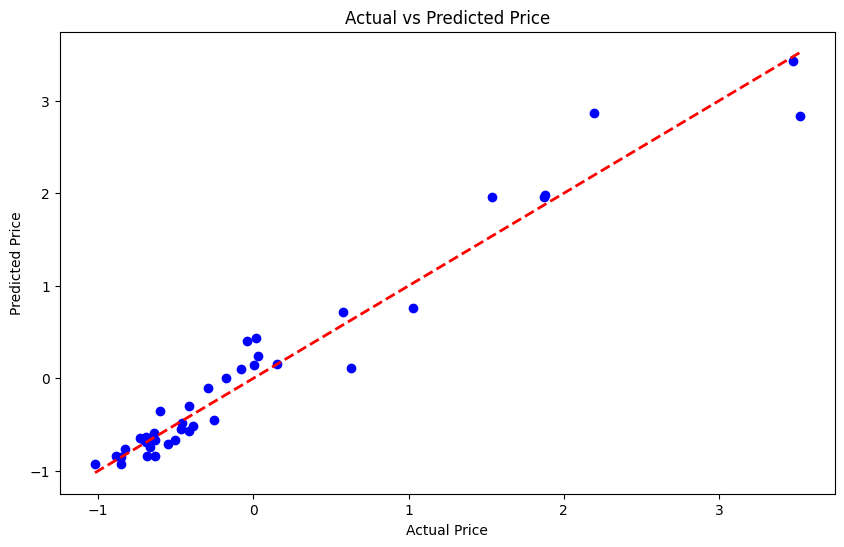

In [400]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()

# **Using Best Parameters in New Model**

In [401]:
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']

In [402]:
best_model = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth,
                                 min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf)

In [403]:
best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=34, n_estimators=358)

In [404]:
best_model.score(X_train, y_train)

0.9877781828255321

In [405]:
y_pred = best_model.predict(X_test)

In [406]:
mse = mean_squared_error(y_test, y_pred)
r2_square = r2_score(y_test,y_pred)
print(f" R-squared: {r2_square}")
print(f'Mean Squared Error: {mse}')

 R-squared: 0.9569025597412142
Mean Squared Error: 0.05357049081437454


# **INSIGHT:**

The scatter plot shows how good our model is at predicting car prices. If the dots are along the diagonal line (red dotted line), this indicates that the predicted and actual prices are almost the same, which is an indication of good performance. The regression coefficient shows the magnitude of the influence of each feature on the car price. The larger the coefficient, the greater its influence on the price of the car. Intercept is the value of the car's price when all features have a value of zero.

# **DETERMINE THE PRICE FROM THE SIZE OF THE MACHINE**

In [407]:
X = data[['enginesize']]  # Menggunakan fitur enginesize sebagai prediktor
y = data['price']

**DIVIDE DATA INTO TRAINING DATA AND TEST DATA**

In [408]:
X_train = X[:-20]
X_test = X[-20:]
y_train = y[:-20]
y_test = y[-20:]

**LINEAR REGRESSION MODEL**

In [409]:
model = LinearRegression()

**TRAIN DATA**

In [410]:
model.fit(X_train, y_train)

LinearRegression()

**PRICE PREDICTION USING TEST DATA**

In [411]:
y_pred = model.predict(X_test)

**DATA VISUALIZATION**

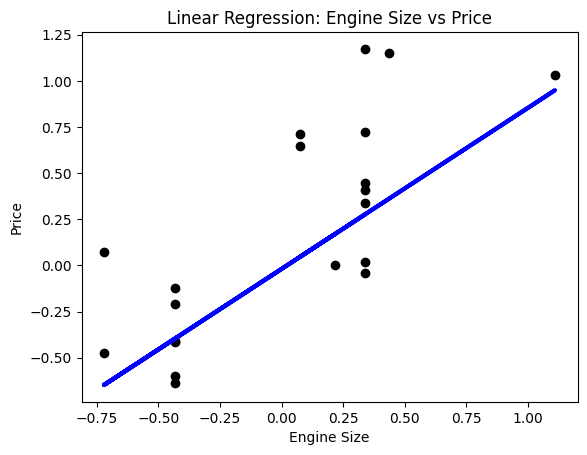

In [412]:
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlabel('Engine Size')
plt.ylabel('Price')
plt.title('Linear Regression: Engine Size vs Price')
plt.show()

**CALCULATING REGRESSION COOFFENSIENTS AND INTERCEPTS**

In [413]:
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Coefficients: [0.87296146]
Intercept: -0.01934990082223402


# **INSIGHT**

**In this case, we use just one feature, namely engine size ('enginesize') to predict the price of the car. From the visualization and regression coefficient results, we can see that there is a positive relationship between engine size and car price, which means the larger the engine size, the higher the car price. Thus, this information can help related parties in determining prices that are appropriate to the size of the car engine they are offering.**